## The Convolutional Neural Network

We will use a convolutional neural network to detect the emotions. 
We will train our model using the FER2013 dataset. Then, using the trained model, we will detect the emotions in the faces detected in the video stream captured by the camera or the video file.


In [54]:
import  tensorflow  as  tf
from  tensorflow  import  keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import train_test_split
import sklearn

import numpy as  np
import matplotlib.pyplot  as  plt
import os
import cv2
import random
import cv2 as cv
import pandas  as  pd
import tqdm as tqdm


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#print the number of GPU

print ( "Num GPUs Available: " ,  len ( tf.config.experimental.list_physical_devices ( 'GPU' )))

Num GPUs Available:  1


2022-12-05 17:10:50.514858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 17:10:50.515165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 17:10:50.515300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 17:10:50.515466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 17:10:50.515581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# Load the dataset

Load and differentiate between training and testing data (they are spit in two folders, one for training and one for testing).

In [55]:
datasetToUse = "GoogleFer" # "CK+48" or "FER2013" or "GoogleFer" or "datasetGigante"

### FER2013 dataset

In [11]:
#load the data
if datasetToUse == "FER2013":
        
        path = "./dataset/FER2013/"
        test_path = path + "test/"
        train_path = path + "train/"


        train_x = []
        train_y = []
        test_x = []
        test_y = []

        #load the train data

        classes = { "angry" : 0,  "disgust" : 1,  "fear" : 2,  "happy" : 3,  "sad" : 4,  "surprise" : 5,  "neutral" : 6}
        classesDiz2 = { 0 : "angry" ,  1 : "disgust" ,  2 : "fear" ,  3 : "happy" ,  4 : "sad" ,  5 : "surprise" ,  6 : "neutral" }

        data_generator = ImageDataGenerator(rescale=1./255)




        batch_size = 32
        # Preprocess all test images
        train_generator = data_generator.flow_from_directory(
                train_path,
                target_size=(48, 48),
                batch_size=64,
                color_mode="grayscale",
                class_mode='categorical')

        # Preprocess all train images
        validation_generator = data_generator.flow_from_directory(
                test_path,
                target_size=(48, 48),
                batch_size=64,
                color_mode="grayscale",
                class_mode='categorical')

                




                



train_x shape:  (32645, 48, 48)
train_y shape:  (32645, 8)
test_x shape:  (8166, 48, 48)
test_y shape:  (8166, 8)


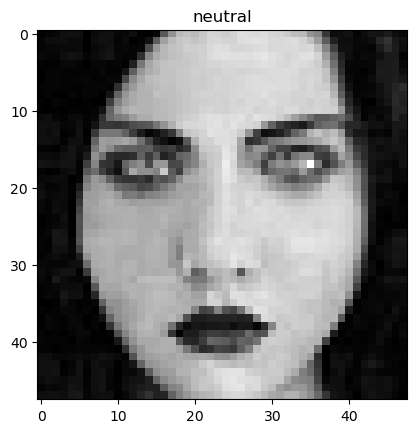

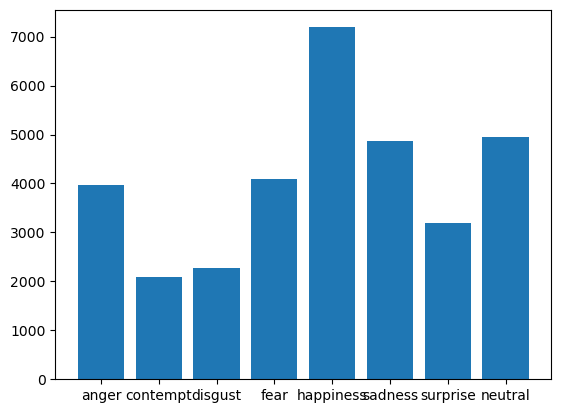

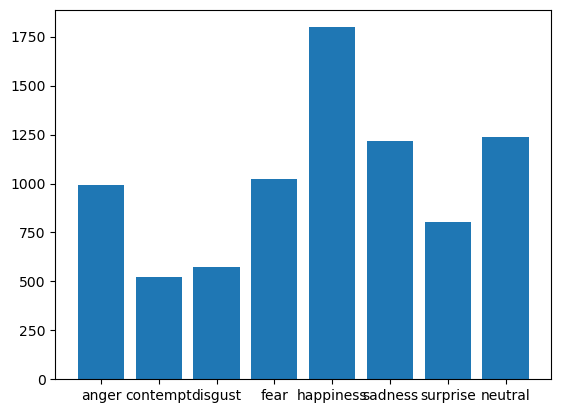

In [56]:
if datasetToUse == "GoogleFer":


        path = "./dataset/GoogleFer/"
        test_path = path + "val/"
        train_path = path + "train/"

        classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happiness" : 4,  "sadness" : 5,  "surprise" : 6,  "neutral" : 7}

        classesReversed = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happiness" ,  5 : "sadness" ,  6 : "surprise" ,  7 : "neutral" }
        num_classes = 8

        batch_size = 32
        


        train_x = []
        train_y = []
        test_x = []
        test_y = []

        #load the train data

        

        contClassesTrain = { "anger" : 0,  "contempt" : 0,  "disgust" : 0,  "fear" : 0,  "happiness" : 0,  "sadness" : 0,  "surprise" : 0,  "neutral" : 0}
        contClassesTest = { "anger" : 0,  "contempt" : 0,  "disgust" : 0,  "fear" : 0,  "happiness" : 0,  "sadness" : 0,  "surprise" : 0,  "neutral" : 0}



        for i in classes:
                #convert i to upper case
                #i = i.upper()    
                path = os.path.join(train_path, i.upper())
                 
                for img in os.listdir(path):
                        img_array = cv2.imread (os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        #new_array = cv2.resize(img_array, (48, 48))
                        train_x.append(img_array)
                        train_y.append(classes[i])
                        contClassesTrain[i] = contClassesTrain[i] + 1

        #load the test data
        for i in classes:
                #i = i.upper()  
                path = os.path.join(test_path, i.upper())
               
                 
                for img in os.listdir(path):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        #new_array = cv2.resize(img_array, (48, 48))
                        test_x.append(img_array)
                        test_y.append(classes[i])
                        contClassesTest[i] = contClassesTest[i] + 1

        #convert the test_x and train_x to numpy array
        train_x = np.array(train_x)
        train_y = keras.utils.to_categorical(train_y, 8)
        test_x = np.array(test_x)
        test_y = keras.utils.to_categorical(test_y, 8)

        print ( "train_x shape: " , train_x.shape)
        print ( "train_y shape: " , train_y.shape)
        print ( "test_x shape: " , test_x.shape)
        print ( "test_y shape: " , test_y.shape)


        data_generator = ImageDataGenerator(rescale=1./255,
                                                rotation_range=30)
        

        #reshape the data
        train_x = train_x.reshape(train_x.shape[0], 48, 48, 1)
        test_x = test_x.reshape(test_x.shape[0], 48, 48, 1)

        train_generator = data_generator.flow(train_x, train_y, batch_size=batch_size)
        validation_generator = data_generator.flow(test_x, test_y, batch_size=batch_size)

        


        randomIndex = random.randint(0, len(train_x))
        #plot the first image
        plt.imshow(train_x[randomIndex].reshape(48, 48), cmap='gray')
        #label it
        plt.title(classesReversed[np.argmax(train_y[randomIndex])])
        plt.show()



        #plot the contClassesTrain
        plt.bar(range(len(contClassesTrain)), list(contClassesTrain.values()), align='center')
        plt.xticks(range(len(contClassesTrain)), list(contClassesTrain.keys()))
        plt.show()

        #plot the contClassesTest
        plt.bar(range(len(contClassesTest)), list(contClassesTest.values()), align='center')
        plt.xticks(range(len(contClassesTest)), list(contClassesTest.keys()))
        plt.show()
        


        





    

### CK+ dataset

CK+ dataset

In [13]:

#load the data
if datasetToUse == "CK+48":
    dataset_path = "./dataset/CK+48/"

    label_images = {
        "anger" : [],
        "contempt" : [],
        "disgust" : [],
        "fear" : [],
        "happy" : [],
        "sadness" : [],
        "surprise" : []
    }

    for folder in os.listdir(dataset_path):
        for file in os.listdir(dataset_path + folder):
            image = cv.imread(dataset_path + folder + "/" + file, 0)

            label_images[folder].append(np.array(image))

    #for each label, take 80% of the images for training and 20% for testing
    train_x = []
    train_y = []
    test_x = []
    test_y = []

    classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happy" : 4,  "sadness" : 5,  "surprise" : 6}
    classesDiz2 = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happy" ,  5 : "sadness" ,  6 : "surprise" }

    for label in label_images:
        cont = 0
        for image in label_images[label]:
            if cont < len(label_images[label]) * 0.8:
                train_x.append(image)
                train_y.append(classes[label])
            else:
                test_x.append(image)
                test_y.append(classes[label])
            cont += 1
            

    train_x = np.array(train_x)
    train_y = np.array(train_y)

    test_x = np.array(test_x)
    test_y = np.array(test_y)

    #print the shape of the data


            

    data_generator = ImageDataGenerator(rescale=1./255)

    #reshape the data
    train_x = train_x.reshape(train_x.shape[0], 48, 48, 1)
    test_x = test_x.reshape(test_x.shape[0], 48, 48, 1)


    print ( "Train data shape: " , train_x.shape)
    print ( "Train labels shape: " , train_y.shape)
    print ( "Test data shape: " , test_x.shape)
    print ( "Test labels shape: " , test_y.shape)


    #convert the labels to categorical
    train_y = keras.utils.to_categorical(train_y, 7)
    test_y = keras.utils.to_categorical(test_y, 7)

 



    # Preprocess all test images
    train_generator = data_generator.flow(
            train_x,
            train_y,    #as the batch size, select the entire dataset
            
    )
    

    # Preprocess all train images
    validation_generator = data_generator.flow(
            test_x,
            test_y,
            
    )


    num_classes = 7
    classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happy" : 4,  "sadness" : 5,  "surprise" : 6}



    

    



    



### Dataset Gigante

In [14]:
if datasetToUse == "datasetGigante":

    path = "./dataset/datasetGigante/"

    #load the CVS that contains the labels
    labels = pd.read_csv(path + "labels.csv")

   #plot the first rows of the labels
    print (labels.head())

    
    #get the number of unique labels
    print ( "Number of unique labels: " , len(labels.label.unique()))

    classes = { "anger" : 0,  "contempt" : 1,  "disgust" : 2,  "fear" : 3,  "happy" : 4,  "sad" : 5,  "surprise" : 6,  "neutral" : 7}

    classesReversed = { 0 : "anger" ,  1 : "contempt" ,  2 : "disgust" ,  3 : "fear" ,  4 : "happy" ,  5 : "sad" ,  6 : "surprise" ,  7 : "neutral" }

    #create a dictionary that contains as key the label and as value an empty list
    label_images = {
        "anger" : [],
        "contempt" : [],
        "disgust" : [],
        "fear" : [],
        "happy" : [],
        "sad" : [],
        "surprise" : [],
        "neutral" : []
    }

    for folder in os.listdir(path):

        #check whether the folder is actually a folder
        if not os.path.isdir(path + folder):
            continue
        #use tqdm to show the progress
        print ( "Loading images from " , folder)
        for file in tqdm.tqdm(os.listdir(path + folder)):
            #the image is in color
            imagePath = path + folder + "/" + file
            imageName = folder + "/" + file
            
            #in the csv, there are two columns: the image name called pth and the label
            #get the label of the image
            label = labels.loc[labels['pth'] == imageName, 'label'].iloc[0]
            
            #load the image is in color
            image = cv.imread(imagePath, cv.IMREAD_GRAYSCALE)
            #resize the image
            image = cv.resize(image, (48, 48))
            
            #add the image to the dictionary
            label_images[label].append(np.array(image))

    #plot 5 images per label
    for label in label_images:
        for i in range(5):
            plt.imshow(label_images[label][i], cmap = "gray")
            plt.title(label)
            plt.show()

    

    #for each label, take 80% of the images for training and 20% for testing
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for label in label_images:
        cont = 0
        for image in label_images[label]:
            if cont < len(label_images[label]) * 0.8:
                train_x.append(image)
                train_y.append(classes[label])
            else:
                test_x.append(image)
                test_y.append(classes[label])
            cont += 1
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    #reshape the data
    train_x = train_x.reshape(train_x.shape[0], 48, 48, 1)
    test_x = test_x.reshape(test_x.shape[0], 48, 48, 1)
    #print the shape of the data
    print ( "Train data shape: " , train_x.shape)
    print ( "Train labels shape: " , train_y.shape)
    print ( "Test data shape: " , test_x.shape)
    print ( "Test labels shape: " , test_y.shape)
    #convert the labels to categorical
    train_y = keras.utils.to_categorical(train_y, 8)
    test_y = keras.utils.to_categorical(test_y, 8)

    data_generator = ImageDataGenerator(rescale=1./255)
    # Preprocess all test images
    train_generator = data_generator.flow(
            train_x,
            train_y,    #as the batch size, select the entire dataset
    )
    # Preprocess all train images
    validation_generator = data_generator.flow(
            test_x,
            test_y,
    )
    num_classes = 8




            

    



    

    


### AffectNet dataset
https://www.kaggle.com/datasets/tom99763/affectnethq

## Train the model

In [57]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Convolution2D, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential



In [54]:
input_shape=(48, 48, 1)
weight_decay = 1e-4

modelType = "EmotionNet"




def EmotionNet():

    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), input_shape=input_shape))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))

    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('softmax'))


    

    return model
    


def modelFromYoutube():

    model = keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


def ResNet():




    pass
                
# create the model

if modelType == "EmotionNet":
    model = EmotionNet()
elif modelType == "modelFromYoutube":
    model = modelFromYoutube()


model.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 activation_33 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 activation_34 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_31 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                     

In [55]:

#train the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

history = model.fit(train_generator, epochs=100, validation_data=validation_generator)


Epoch 1/100


/home/theshadow/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1021/1021 [==============================] - 27s 26ms/step - loss: 2.4103 - accuracy: 0.2682 - val_loss: 1.9823 - val_accuracy: 0.3811
Epoch 2/100
1021/1021 [==============================] - 27s 26ms/step - loss: 2.0236 - accuracy: 0.3696 - val_loss: 1.8171 - val_accuracy: 0.4410
Epoch 3/100
1021/1021 [==============================] - 27s 26ms/step - loss: 1.8594 - accuracy: 0.4259 - val_loss: 1.7340 - val_accuracy: 0.4897
Epoch 4/100
1021/1021 [==============================] - 27s 26ms/step - loss: 1.7414 - accuracy: 0.4642 - val_loss: 1.5898 - val_accuracy: 0.5138
Epoch 5/100
1021/1021 [==============================] - 27s 27ms/step - loss: 1.6691 - accuracy: 0.4937 - val_loss: 1.5280 - val_accuracy: 0.5404
Epoch 6/100
1021/1021 [==============================] - 27s 27ms/step - loss: 1.5893 - accuracy: 0.5205 - val_loss: 1.4746 - val_accuracy: 0.5596
Epoch 7/100
1021/1021 [==============================] - 27s 27ms/step - loss: 1.5377 - accuracy: 0.5371 - val_loss: 1.4563 - val_

KeyboardInterrupt: 

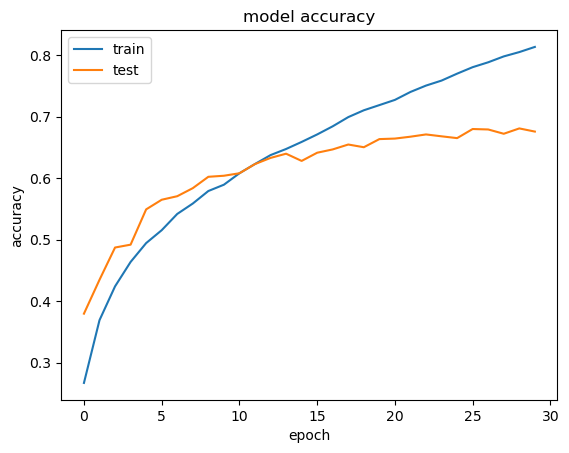

In [56]:

#plot the accuracy and loss
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [57]:
#save the model as model name
model.save("modelEmotionNet+GoogleFer2.h5")


# Setup the application

In [58]:
#import the module to read from webcam 
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras



The cell below captures a video stream of the camera and displays it in the notebook. The video stream is captured using the OpenCV library. 
If we want to capture from a video file, we can use the following code:

cv.VideoCapture('project_video.mp4')

On the other hand, if we want to use the camera, we can use the following code:

cv.VideoCapture(0)


In [59]:
videoPath = "METTERE QUI IL PATH DEL VIDEO"

if videoPath == "METTERE QUI IL PATH DEL VIDEO" or videoPath == "":
    cap = cv.VideoCapture(0)
else:
    cap = cv.VideoCapture(videoPath)

#there are 7 emotions
num_classes = 7

classes = classesReversed
print(classes)

    


{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise', 7: 'neutral'}


Below, we will choose if we want to dected the frontal faces, the profile or both. We will use the frontal face cascade classifier by default.

In [60]:
haarDetectionMode = "profile"

In [61]:
haarDetectionMode = "profileAndFrontal"

In [62]:
haarDetectionMode = "frontal"

In [63]:
saveCroppedFaces = False
predictEmotions = True

The function detect faces uses haar cascade to detect faces in the frame. 
There are two versions of haar cascades, one for profile faces and one for frontal faces.



In [64]:
def detectFaces(frame):

    detectedFaces = []


    #use haar cascade to detect faces
    if haarDetectionMode == "frontal" or haarDetectionMode == "profileAndFrontal":
        faceCascadeFrontal = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        facesFrontal = faceCascadeFrontal.detectMultiScale(frame, 1.1, 4)

        detectedFaces.extend(facesFrontal)

    elif haarDetectionMode == "profile" or haarDetectionMode == "profileAndFrontal":
        faceCascadeProfile = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_profileface.xml')
        facesProfile = faceCascadeProfile.detectMultiScale(frame, 1.1, 4)

        detectedFaces.extend(facesProfile)




    

    return detectedFaces

In [65]:
def drawRectangleFace(frame, facesCoordinates):
    #draw the rectangle around the face
    frameWithRectangle = frame.copy()
    for (x, y, w, h) in facesCoordinates:
        cv.rectangle(frameWithRectangle, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    return frameWithRectangle
        
        
    
        

In [66]:
def plotImage(image):
    plt.imshow(image)
    plt.show()

In [67]:
def predictEmotion(face):
    #resize the image
    face = cv.resize(face, (48, 48))

    #convert the image to float
    face = face.astype('float32')
    #normalize the image
    face /= 255
    #reshape the image
    face = face.reshape(1, 48, 48, 1)
    #predict the emotion
    emotion = model.predict(face)
    return emotion

In [68]:
if predictEmotions:
    #load the model
    model = keras.models.load_model('modelEmotionNet+GoogleFer2.h5')
    

In [69]:
def writeEmotionOnImage(frame, facesCoordinates, emotions):
    frameWithEmotion = frame.copy()
    for (x, y, w, h), emotion in zip(facesCoordinates, emotions):
        #get the emotion with the highest probability and write the confidence
        emotion1 = classes[np.argmax(emotion)]
        confidence = np.max(emotion)
        cv.putText(frameWithEmotion, emotion1 + " " + str(confidence), (x, y), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv.LINE_AA)



        

    return frameWithEmotion

In [70]:

def showVideo():
    ret,frame = cap.read()

    if not ret:
        print("Unable to capture video")
        exit()
        
    
    #flip the image
    frame = cv.flip(frame,1)
    grayFrame = frame
    #convert the image to grayscale
    if frame is not None:
        grayFrame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        

    

    #detect the face
    facesCoordinates = detectFaces(grayFrame)

    #draw the rectangle around the face
    frameToShow = drawRectangleFace(frame, facesCoordinates)

    if predictEmotions:

        emotions = []
        for (x, y, w, h) in facesCoordinates:
            #crop the face
            face = grayFrame[y:y+h, x:x+w]
            face = cv.resize(face, (48, 48))
            #convert to numpy array
            face = np.array(face)
            face.reshape(48, 48, 1)

            #save the face
            if saveCroppedFaces:
                cv.imwrite("./savedFaces/face.jpg", face)
            
            
            #print the shape


            #face to grayscale

            #predict the emotion
            emotion = predictEmotion(face)
            emotions.append(emotion)
            

        frameToShow = writeEmotionOnImage(frameToShow, facesCoordinates, emotions)


    #display the image
    cv.imshow('frame',frameToShow)
    ret = True
    if cv.waitKey(1) & 0xFF == ord('q'):
        ret = False
        
    return ret, frame, facesCoordinates

In [71]:
ret = True
while ret:
    
    

    #show the video with the face detected
    ret, frame, facesCoordinates = showVideo()


                
            
    
#release the camera
cap.release()
#close all windows
cv.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step


# Feature Extraction using VGG16

In [72]:
#import the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.neighbors import KNeighborsClassifier

#extract the features from the images
def extractFeatures(images):
    features = featuatureExtractionModel.predict(images)
    #reshape the features
    features = features.reshape(features.shape[0], -1)
    return features



featuatureExtractionModel = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

#freeze the layers
for layer in featuatureExtractionModel.layers:
    layer.trainable = False


train_x = []
train_y = []

val_x = []
val_y = []


for folder in os.listdir("./dataset/GoogleFer/train/"):
    for file in os.listdir("./dataset/GoogleFer/train/" + folder):
        image = cv.imread("./dataset/GoogleFer/train/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        train_x.append(image)
        train_y.append(folder)

for folder in os.listdir("./dataset/GoogleFer/val/"):
    for file in os.listdir("./dataset/GoogleFer/val/" + folder):
        image = cv.imread("./dataset/GoogleFer/val/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        val_x.append(image)
        val_y.append(folder)





train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = np.array(val_x)
val_y = np.array(val_y)



print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)



train_x = extractFeatures(train_x)
test_x = extractFeatures(val_x)
print("Finished extracting features")






(32645, 48, 48, 3)
(32645,)
(8166, 48, 48, 3)
(8166,)
256/256 [==============================] - 2s 7ms/step
Finished extracting features


In [73]:
#train a softmax classifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_x, train_y)

#evaluate the model
print(classifier.score(test_x, val_y))


0.4310555963752143


# Try my code

In [74]:
#load my model 
model = keras.models.load_model('modelEmotionNet+GoogleFer2.h5')

flag = True

#create a new model starting from model until flatten
newModel = keras.models.Model(inputs=model.input, outputs=model.get_layer('dropout_21').output)
newModel.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLayer  [(None, 48, 48, 1)]      0         
 )                                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 activation_33 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 activation_34 (Activation)  (None, 48, 48, 64)        0   

In [75]:

train_x = []
train_y = []

val_x = []
val_y = []


for folder in os.listdir("./dataset/GoogleFer/train/"):
    for file in os.listdir("./dataset/GoogleFer/train/" + folder):
        image = cv.imread("./dataset/GoogleFer/train/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        #convert to grayscale
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        train_x.append(image)
        train_y.append(folder)

for folder in os.listdir("./dataset/GoogleFer/val/"):
    for file in os.listdir("./dataset/GoogleFer/val/" + folder):
        image = cv.imread("./dataset/GoogleFer/val/" + folder + "/" + file)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        #convert to grayscale
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        val_x.append(image)
        val_y.append(folder)





train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = np.array(val_x)
val_y = np.array(val_y)



print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)



(32645, 48, 48)
(32645,)
(8166, 48, 48)
(8166,)


In [76]:
def extractFeatures(model, images):
    features = model.predict(images)
    #reshape the features
    features = features.reshape(features.shape[0], -1)
    return features
    

In [77]:
train_x = extractFeatures(newModel, train_x)
test_x = extractFeatures(newModel, val_x)
print("Finished extracting features")

256/256 [==============================] - 1s 5ms/step
Finished extracting features


In [78]:
#train a softmax classifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_x, train_y)

#evaluate the model
print(classifier.score(test_x, val_y))


0.4481998530492285
